#Overview


* This notebook was created in colab and meant to interface with our team's GCP Bucket (mounts). Link to colab notebook [here](https://drive.google.com/file/d/1GmVixIsCiJLqACfepLAC9mO-gr-Q9-m_/view?usp=sharing).
* Milestone versions of this notebook are in [github](https://github.com/dyeramosu/ac215_snapnutrition)
* This notebook has 2 sections 1) data exploration and 2) model building
* This beginning notebook also helped us to figure out what data we need and what needs to be pre-processed.


# Nutrition5k Dataset EDA



## Nutrition5K Paper DataSource Overview

*   Nurtiion5k paper had their data in a GCP bucket. They have a Google Bucket link [here](https://console.cloud.google.com/storage/browser/nutrition5k_dataset;tab=objects?prefix=&forceOnObjectsSortingFiltering=false)
*   Bucket size total of 181 GB (includes photos and 360-degree surround food videos)
*   Nutrition5k is a medium dataset (less than 2TB). It will not fit in RAM but maybe in local disk
*   Nutrition5k papers did not attempt to identify the food in the images unlike FOODD. Instead it tried to use images at various angles and later depth images.


1) First we'll need to extract the unique ID for each dish image. We will also need the corresponding nutrition info of each food image. The following csv's contain all nutrition metadata at the dish_id-level, as well as per-ingredient mass and macronutrients. The default directory structure is:

```
  └── nutrition5k_dataset
        └──metadata
           ├── dish_metadata_cafe1.csv
           └── dish_metadata_cafe2.csv
```
For each dish ID dish_[10 digit timestamp], there is a CSV entry containing the following fields:

```
dish_id, total_calories, total_mass, total_fat, total_carb, total_protein, num_ingrs,
(ingr_1_id, ingr_1_name, ingr_1_grams, ingr_1_calories, ingr_1_fat, ingr_1_carb, ingr_1_protein, ...)
with the last 8 fields are repeated for every ingredient present in the dish.
```
Note: There is a seperate CSV for each ingredient ID and their nutrition info at:

```
nutrition5k_dataset/nutrition5k_dataset/metadata/ingredients_metadata.csv
```

2) Second we'll need to extract the overhead shot of each image using dish_id. We will ognore the depth shots for each dish_id for now. The default directory structure we will look into is:

```
  └── nutrition5k_dataset
        └──imagery
            └── realsense_overhead
                 ├──dish_{ID}
                 │   ├── depth_color.png
                 │   ├── depth_raw.png
                 │   └── rbg.png
                 ├──dish_{ID}...
                 ...                  
```



## Mount Team SnapNutrition GCP Bucket To Colab

Instead of reading files directly from Nutrion5k's GCP bucket, we transferred a subset of the files of interest (excluding video files) into our own bucket for versioning.

From now on we will use our GCP bucket data source [direct link](https://console.cloud.google.com/storage/browser/snapnutrition_data_bucket?authuser=0&project=csci-115-398800&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)

In [1]:
#cell to connect to our GCP Bucket
from google.colab import auth

auth.authenticate_user()

#THIS WILL CREATE A GOOGLE POP-UP WINDOW TO LOGIN
#If you do not have access to our bucket, please message brent ruttle

In [2]:
!gcloud config set project csci-115-398800

Updated property [core/project].


Install package needed to mount GCP Bucket to colab

In [3]:
!echo "deb https://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  27786      0 --:--:-- --:--:-- --:--:-- 27989
OK
19 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 5,558 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 120874 files and directories c

Make a directory and mount GCP bucket "snapnutrition_data_bucket" to the folder

In [4]:
!mkdir snapnutrition_data_bucket
!gcsfuse --implicit-dirs snapnutrition_data_bucket snapnutrition_data_bucket
!gcsfuse --implicit-dirs snapnutrition_data_bucket/data/tf_records snapnutrition_data_bucket/data/tf_records

#!chmod 777 -R snap_nutrition_data

{"time":"23/10/2023 03:35:47.366554","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snapnutrition_data_bucket\n"}
{"time":"23/10/2023 03:35:47.770063","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snapnutrition_data_bucket/data/tf_records\n"}
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithStorageHandle: fs.NewServer: create file system: SetUpBucket: Error in iterating through objects: storage: bucket doesn't exist


In [5]:
pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.6 MB/s eta 0:00:00


##Exploratory Data Analysis (EDA)

In [6]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import time
import subprocess
from glob import glob


# sklearn
from sklearn.model_selection import train_test_split

import requests
import tempfile
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
import random
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# TF Hub
import tensorflow_hub as hub

# TF Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude



AUTOTUNE = tf.data.AUTOTUNE
#constants for using the Nutrition5k Research Paper's Public Google Bucket
GOOGLE_BUCKET_DOMAIN = "https://storage.googleapis.com/"
DISH_IMAGES_DIRECTORY = "nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/"

TFRECORDS_DIRECTORY = "snapnutrition_data_bucket/data/tf_records/224_by_224"

In [7]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
#print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set the global random seed
tf.random.set_seed(215)
np.random.seed(215)
random.seed(215)

tensorflow version 2.13.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
!nvidia-smi

Mon Oct 23 03:36:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |    361MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Note: set aside size, need later for optimal prune batching

In [9]:
# paths to read train test val data (has image filepaths and corresponding labels
TEST_SAVE_PATH = "./snapnutrition_data_bucket/data/processed_labels/test_data.pickle"

# read train, test, validation data from pickle files
test_xy = pd.read_pickle(TEST_SAVE_PATH)

len(test_xy) #set aside size, need later for optimal prune batching

489

In [10]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
NUM_CHANNELS = 3
batch_size = 128
num_macros = 5

In [11]:
#FORMATTEST METRICS

actual_calories = []
actual_mass = []
actual_fat = []
actual_carb = []
actual_protein = []
y_test  = []

for i, element in enumerate(test_xy):
  actual_calories.append(float(element[0][0]))
  actual_mass.append(float(element[0][1]))
  actual_fat.append(float(element[0][2]))
  actual_carb.append(float(element[0][3]))
  actual_protein.append(float(element[0][4]))
  y_test.append([float(element[0][0]),float(element[0][1]), float(element[0][2]), float(element[0][3]), float(element[0][4])])

In [12]:
#UTILIY FUNCTIONS

def compare_model_sizes(model):
  _, model_file = tempfile.mkstemp(".h5")
  tf.keras.models.save_model(model, model_file, include_optimizer=False)
  # Zip the .h5 model file
  _, zip3 = tempfile.mkstemp(".zip")
  with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
      f.write(model_file)
  model_before_zip = os.path.getsize(model_file) / float(1000)
  model_after_zip = os.path.getsize(zip3) / float(1000)
  print("Model before zip: %.2f Kb"% model_before_zip)
  print("Model after zip: %.2f Kb"% model_after_zip)
  return model_before_zip, model_after_zip

def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = "models"
def save_model(model,model_train_history,execution_time, learning_rate, epochs,
               optimizer, evaluation_results, before_zip_size, after_zip_size, inference_time,
               avg_calories_off, avg_mass_off, avg_fat_off, avg_carb_off, avg_protein_off, min_calories_off,
               min_mass_off, min_fat_off, min_carb_off, min_protein_off, max_calories_off, max_mass_off,
               max_fat_off, max_carb_off, max_protein_off):
  model_name=model.name

  # Ensure path exists
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)
  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

  model_size = get_model_size(model_name=model.name)

  # Save model history
  with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)

  # Save model metrics
  metrics ={
      "trainable_parameters":trainable_parameters,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "root_mean_squared_error":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "batch_size":batch_size,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__,
      "before_zip_size": before_zip_size,
      "after_zip_size": after_zip_size,
      "test_set_inference_time(min)": inference_time,
      "avg_calories_off":avg_calories_off,
      "avg_mass_off": avg_mass_off,
      "avg_fat_off": avg_fat_off,
      "avg_carb_off": avg_carb_off,
      "avg_protein_off": avg_protein_off,
      "min_calories_off": min_calories_off,
      "min_mass_off": min_mass_off,
      "min_fat_off": min_fat_off,
      "min_carb_off": min_carb_off,
      "min_protein_off": min_protein_off,
      "max_calories_off": max_calories_off,
      "max_mass_off": max_mass_off,
      "max_fat_off": max_fat_off,
      "max_carb_off": max_carb_off,
      "max_protein_off": max_protein_off
  }
  with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".hdf5")).st_size
  return model_size


### Create TF Records

Choose the appropriate notebook to create the size and normalization type you need. https://drive.google.com/drive/folders/17gj5pSqvcz3tkCDm3NJCWLPNfVvOwc0P?usp=share_link

# Model Building

1. full_label_df connects unique dish_id's to the nutrition info
2. dish_id also corresponds to the image directory to get the regular png (we will exclude depth images for now)

**Model Input:** will be the overhead image png


**Model Output:** will be (total_calories, total_mass, total_fat, total_carb, total_protein)


Followed this tutorial for loading images via tensorflow https://www.tensorflow.org/tutorials/load_data/images

## Load TF Data from TFRecords

In [13]:
from IPython.testing import test


# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([5], tf.float32, default_value=[0.0, 0.0, 0.0, 0.0, 0.0])
}

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.float32)
  image.set_shape([NUM_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH])
  image = tf.reshape(image, [IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS])
  # Label
  label = parsed_example['label']

  return image, label

# # Normalize pixels
# def normalize(image, label):
#   image = image/255
#   return image, label

# Read the tfrecord files
train_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/train*')
validate_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/val*')
test_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/test*')


#############
# Train data
#############
train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
train_data = train_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

##################
# Validation data
##################
validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
validation_data = validation_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#validation_data = validation_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE)

##################
# Test data
##################
test_data = test_tfrecord_files.flat_map(tf.data.TFRecordDataset)
test_data = test_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#test_data = test_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)


train_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
validation_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
test_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


https://colab.research.google.com/drive/18FBb3MiV4IcPPcJmteLZvE727Ec2QAhA?usp=sharing#scrollTo=uHAXY_VwmjAQ

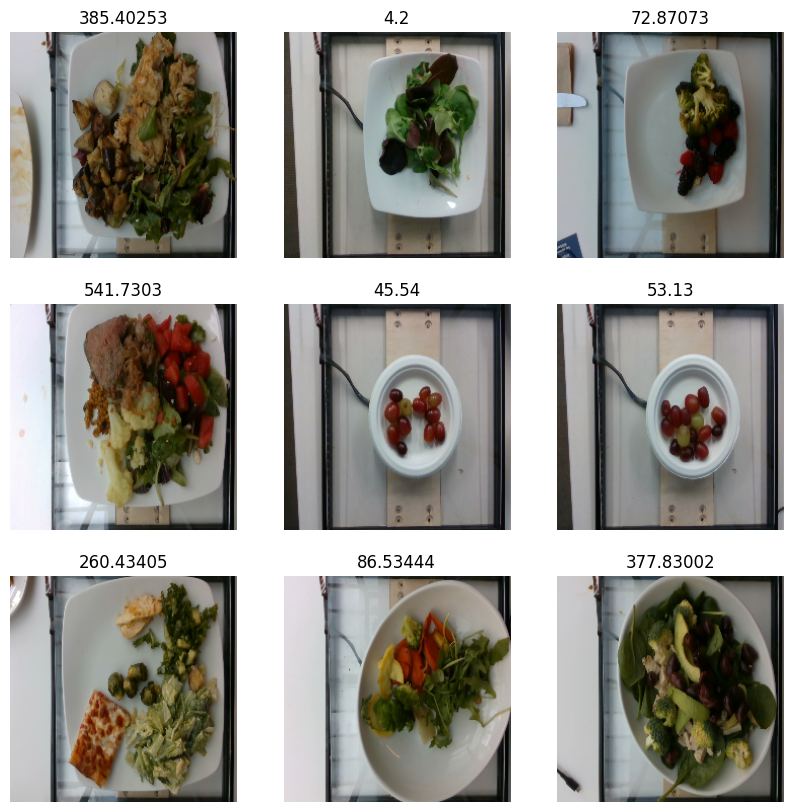

In [14]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch[i].numpy()
  #img = (img + dask_computed_metrics['mean']) * dask_computed_metrics['stdev']
  img = img.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
  img = img.astype(np.uint8)

  plt.imshow(img)
  label = label_batch[i]
  plt.title(label.numpy()[0]) #preview calories only
  plt.axis("off")

The above images with total calories at the title look like the data has been set-up correctly. Calories visually seem to make sense too. Note that we have other macro info, but are only displaying the calories for this preview.

**Next standardize the data in case missed in preprocessing pipeline**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

### Build Teacher Model

#### **Teacher Model**

Teacher model is a mobilenet_v2 model which we get from directly from tfhub.

In [15]:
#Attempt Grid Search?
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier

In [16]:
# #training params
# learning_rate = 0.001
# initial_epoch = 0
# epochs = 20
# num_macros = 5

# # Regularize using L1
# kernel_weight = 0.02
# bias_weight = 0.02

Formatting Guide Transfer Learning:
https://keras.io/guides/transfer_learning/


In [23]:
NAME = 'VGG16_teacher_model_Builtin'
from keras.applications.vgg16 import preprocess_input



def build_teacher_model(image_height, image_width, num_channels, num_classes):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  base_model = keras.applications.VGG16(
      include_top=False,
      weights="imagenet",
      input_tensor=None
  )

  base_model.trainable = False

  inputs = keras.Input(shape = (image_height, image_width, num_channels))
  X = preprocess_input(inputs)
  # We make sure that the base_model is running in inference mode here,
  # by passing `training=False`. This is important for fine-tuning, as you will
  # learn in a few paragraphs.
  x = base_model(X, training=False)
  # Convert features of shape `base_model.output_shape[1:]` to vectors
  x = keras.layers.GlobalAveragePooling2D()(x)
  # A Dense classifier with a single unit (binary classification)
  outputs = keras.layers.Dense(units=num_classes)(x)
  model = keras.Model(inputs, outputs)

  # model = Sequential([
  #       keras.layers.InputLayer(input_shape=input_shape),
  #                               hub.KerasLayer(handle, trainable=False),
  #       keras.layers.Dense(units=64, activation='relu'),
  #       keras.layers.Dense(units=num_classes)
  # ], name='teacher_model')

  return model

#### **Train Teacher**

Nothing magical about this step. We just train the teacher network.

In [18]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=405119083577ef793a5401c9f584c216a7582b5cd706a3d7addb50d06672771f
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [19]:
# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger

# Login to W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

https://wandb.ai/wandb_fc/articles/reports/Running-Hyperparameter-Sweeps-to-Pick-the-Best-Model--Vmlldzo1NDQ0OTIy

![](https://api.wandb.ai/files/wandb_fc/images/projects/38184289/12729e82.png)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

teacher_model = build_teacher_model(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_macros)
ES_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)


def train_model():
    wandb.init(project = 'snap-nutrition')

    # model = teacher_model(
    #     #learning_rate=wandb.config.learning_rate,
    #     epochs=wandb.config.epochs,
    #     loss=keras.losses.MeanAbsoluteError(),
    #     metrics=[keras.metrics.RootMeanSquaredError()],
    #     optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    # )

    teacher_model.compile(optimizer=keras.optimizers.SGD(wandb.config.learning_rate),
                      loss=wandb.config.loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])

    teacher_model.fit(train_data,
        validation_data=validation_data,
        epochs=wandb.config.epochs, callbacks = [ES_callback], verbose=1)

    # Predict on val set
    y_preds = teacher_model.predict(test_data)

    # Evaluate predictions
    mae_score = mean_absolute_error(y_test, y_preds)
    mse_score = mean_squared_error(y_test, y_preds)

    full_test_predicted = y_preds
    full_test_results = {'actual_calories': actual_calories, 'pred_calories': full_test_predicted[:, 0], 'actual_mass': actual_mass, 'pred_mass':full_test_predicted[:, 1],
                    'actual_fat': actual_fat, 'pred_fat': full_test_predicted[:, 2], 'actual_carb': actual_carb, 'pred_carb': full_test_predicted[:, 3],'actual_protein': actual_protein, 'pred_protein':full_test_predicted[:,4]}
    full_test_results_df = pd.DataFrame(data=full_test_results)
    full_test_results_df['calorie_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_calories'] - x['pred_calories']), axis=1)
    full_test_results_df['mass_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_mass'] - x['pred_mass']), axis=1)
    full_test_results_df['fat_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_fat'] - x['pred_fat']), axis=1)
    full_test_results_df['carb_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_carb'] - x['pred_carb']), axis=1)
    full_test_results_df['protein_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_protein'] - x['pred_protein']), axis=1)
    avg_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].mean()
    avg_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].mean()
    avg_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].mean()
    avg_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].mean()
    avg_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].mean()
    min_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].min()
    min_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].min()
    min_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].min()
    min_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].min()
    min_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].min()
    max_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].max()
    max_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].max()
    max_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].max()
    max_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].max()
    max_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].max()

    # Log model performance metrics to W&B
    wandb.log({
      "mae": mae_score,
      "mse": mse_score,
      "avg_calories_off":avg_calories_off,
      "avg_mass_off": avg_mass_off,
      "avg_fat_off": avg_fat_off,
      "avg_carb_off": avg_carb_off,
      "avg_protein_off": avg_protein_off,
      "min_calories_off": min_calories_off,
      "min_mass_off": min_mass_off,
      "min_fat_off": min_fat_off,
      "min_carb_off": min_carb_off,
      "min_protein_off": min_protein_off,
      "max_calories_off": max_calories_off,
      "max_mass_off": max_mass_off,
      "max_fat_off": max_fat_off,
      "max_carb_off": max_carb_off,
      "max_protein_off": max_protein_off
      })


sweep_configs = {
    "name": f'{NAME}_Sweep',
    "method": "grid",
    "metric": {"name": "mse", "goal": "minimize"},
    "parameters": {
        #"learning_rate": {"distribution": "uniform", "min": 0, "max": 0.1},
        "learning_rate": {"values": [0.001, 0.01, 0.05, 0.1]},
        "epochs": {"values": [100]},
        "loss": {"values": ["mae","mse"]}
    }
}

sweep_id = wandb.sweep(sweep_configs, project = 'snap-nutrition')
wandb.agent(sweep_id=sweep_id, function=train_model)

58889256/58889256 [==============================] - 2s 0us/step
Create sweep with ID: 1u59esth
Sweep URL: https://wandb.ai/snap-nutrition/snap-nutrition/sweeps/1u59esth


wandb: Agent Starting Run: s3tpitp2 with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	loss: mae
wandb: Currently logged in as: wschristina (snap-nutrition). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
18/18 [==============================] - 114s 5s/step - loss: 98.6492 - root_mean_squared_error: 190.4720 - val_loss: 90.7591 - val_root_mean_squared_error: 177.9229
Epoch 2/100
18/18 [==============================] - 11s 623ms/step - loss: 89.7273 - root_mean_squared_error: 180.0598 - val_loss: 83.4871 - val_root_mean_squared_error: 168.3218
Epoch 3/100
18/18 [==============================] - 11s 617ms/step - loss: 83.2198 - root_mean_squared_error: 171.2344 - val_loss: 77.9347 - val_root_mean_squared_error: 160.2431
Epoch 4/100
18/18 [==============================] - 11s 617ms/step - loss: 78.2054 - root_mean_squared_error: 163.8910 - val_loss: 73.6924 - val_root_mean_squared_error: 153.4749
Epoch 5/100
18/18 [==============================] - 11s 625ms/step - loss: 74.3133 - root_mean_squared_error: 157.6565 - val_loss: 70.3297 - val_root_mean_squared_error: 147.6369
Epoch 6/100
18/18 [==============================] - 11s 624ms/step - loss: 71.2120 - root_mean_square

avg_calories_off,▁
avg_carb_off,▁
avg_fat_off,▁
avg_mass_off,▁
avg_protein_off,▁
mae,▁
max_calories_off,▁
max_carb_off,▁
max_fat_off,▁
max_mass_off,▁
max_protein_off,▁


wandb: Agent Starting Run: xndjo0qc with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	loss: mse
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
18/18 [==============================] - 12s 632ms/step - loss: 140588880.0000 - root_mean_squared_error: 11857.0176 - val_loss: 3433496320.0000 - val_root_mean_squared_error: 58596.0469
Epoch 2/100
18/18 [==============================] - 11s 636ms/step - loss: 828996468080640.0000 - root_mean_squared_error: 28792298.0000 - val_loss: 20959339472748544.0000 - val_root_mean_squared_error: 144773408.0000
Epoch 3/100
18/18 [==============================] - 12s 651ms/step - loss: 5271382299043872899072.0000 - root_mean_squared_error: 72604286976.0000 - val_loss: 141213320677557457125376.0000 - val_root_mean_squared_error: 375783620608.0000
Epoch 4/100
18/18 [==============================] - 11s 629ms/step - loss: 32535808777372307804754280448.0000 - root_mean_squared_error: 180376832049152.0000 - val_loss: 929112307320586934873766232064.0000 - val_root_mean_squared_error: 963904679182336.0000
Epoch 5/100
18/18 [==============================] - 11s 615ms/step - loss: inf - ro

avg_calories_off,▁
avg_carb_off,▁
avg_fat_off,▁
avg_mass_off,▁
avg_protein_off,▁
mae,▁
max_calories_off,▁
max_carb_off,▁
max_fat_off,▁
max_mass_off,▁
max_protein_off,▁


wandb: Agent Starting Run: 7th0jaun with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	loss: mae
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
18/18 [==============================] - 12s 625ms/step - loss: 4452694033407443730432.0000 - root_mean_squared_error: inf - val_loss: 4408122752320288063488.0000 - val_root_mean_squared_error: inf
Epoch 2/100
18/18 [==============================] - 11s 626ms/step - loss: 4452694033407443730432.0000 - root_mean_squared_error: inf - val_loss: 4408122470845311352832.0000 - val_root_mean_squared_error: inf
Epoch 3/100
18/18 [==============================] - 12s 646ms/step - loss: 4452694596357397151744.0000 - root_mean_squared_error: inf - val_loss: 4408122752320288063488.0000 - val_root_mean_squared_error: inf
Epoch 4/100
18/18 [==============================] - 11s 640ms/step - loss: 4452694596357397151744.0000 - root_mean_squared_error: inf - val_loss: 4408122470845311352832.0000 - val_root_mean_squared_error: inf
Epoch 5/100
18/18 [==============================] - 11s 621ms/step - loss: 4452694033407443730432.0000 - root_mean_squared_error: inf - val_loss: 4408122752320

avg_calories_off,▁
avg_carb_off,▁
avg_fat_off,▁
avg_mass_off,▁
avg_protein_off,▁
mae,▁
max_calories_off,▁
max_carb_off,▁
max_fat_off,▁
max_mass_off,▁
max_protein_off,▁


wandb: Agent Starting Run: elt4m7t6 with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	loss: mse
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
18/18 [==============================] - 12s 619ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/100
18/18 [==============================] - 11s 619ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/100
18/18 [==============================] - 11s 643ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/100
18/18 [==============================] - 11s 643ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/100
4/4 [==============================] - 2s 645ms/step


Run elt4m7t6 errored: ValueError('Input contains NaN.')
wandb: ERROR Run elt4m7t6 errored: ValueError('Input contains NaN.')
wandb: Agent Starting Run: 6crjxe2a with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 0.05
wandb: 	loss: mae
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
18/18 [==============================] - 12s 624ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/100
18/18 [==============================] - 11s 618ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/100
18/18 [==============================] - 11s 642ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/100
18/18 [==============================] - 12s 646ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/100
4/4 [==============================] - 2s 654ms/step


Run 6crjxe2a errored: ValueError('Input contains NaN.')
wandb: ERROR Run 6crjxe2a errored: ValueError('Input contains NaN.')
wandb: Agent Starting Run: an8obryk with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 0.05
wandb: 	loss: mse
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
18/18 [==============================] - 12s 618ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/100
18/18 [==============================] - 11s 618ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/100
18/18 [==============================] - 11s 641ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/100
18/18 [==============================] - 12s 645ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/100
4/4 [==============================] - 2s 639ms/step


Run an8obryk errored: ValueError('Input contains NaN.')
wandb: ERROR Run an8obryk errored: ValueError('Input contains NaN.')
wandb: Agent Starting Run: nxgek8ie with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	loss: mae
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
18/18 [==============================] - 12s 617ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/100
18/18 [==============================] - 11s 618ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/100
18/18 [==============================] - 11s 641ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/100
18/18 [==============================] - 12s 646ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/100
4/4 [==============================] - 2s 645ms/step


Run nxgek8ie errored: ValueError('Input contains NaN.')
wandb: ERROR Run nxgek8ie errored: ValueError('Input contains NaN.')
wandb: Agent Starting Run: 3169ykq2 with config:
wandb: 	epochs: 100
wandb: 	learning_rate: 0.1
wandb: 	loss: mse
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/100
18/18 [==============================] - 12s 619ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/100
18/18 [==============================] - 11s 618ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/100
18/18 [==============================] - 11s 641ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/100
18/18 [==============================] - 12s 645ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/100
4/4 [==============================] - 2s 642ms/step


Run 3169ykq2 errored: ValueError('Input contains NaN.')
wandb: ERROR Run 3169ykq2 errored: ValueError('Input contains NaN.')
wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Example Project with Weights and Biases Sweep (Like Grid-Search)

https://github.com/wandb/examples/blob/master/examples/wandb-sweeps/sweeps-xgboost/xgboost_tune.py



In [25]:
full_test_predicted = teacher_model.predict(test_data)
full_test_predicted[:5]

4/4 [==============================] - 2s 626ms/step


array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)

Look at Performance Metrics of Saved Model

In [26]:
model = teacher_model

#should only see big differences if pruned and have 0 weights
before_zip_size, after_zip_size = compare_model_sizes(model)

#let's just get the y_pred
full_test_predicted = model.predict(test_data)
full_test_results = {'actual_calories': actual_calories, 'pred_calories': full_test_predicted[:, 0], 'actual_mass': actual_mass, 'pred_mass':full_test_predicted[:, 1],
                    'actual_fat': actual_fat, 'pred_fat': full_test_predicted[:, 2], 'actual_carb': actual_carb, 'pred_carb': full_test_predicted[:, 3],'actual_protein': actual_protein, 'pred_protein':full_test_predicted[:,4]}
full_test_results_df = pd.DataFrame(data=full_test_results)
full_test_results_df['calorie_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_calories'] - x['pred_calories']), axis=1)
full_test_results_df['mass_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_mass'] - x['pred_mass']), axis=1)
full_test_results_df['fat_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_fat'] - x['pred_fat']), axis=1)
full_test_results_df['carb_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_carb'] - x['pred_carb']), axis=1)
full_test_results_df['protein_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_protein'] - x['pred_protein']), axis=1)
avg_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].mean()
avg_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].mean()
avg_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].mean()
avg_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].mean()
avg_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].mean()
min_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].min()
min_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].min()
min_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].min()
min_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].min()
min_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].min()
max_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].max()
max_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].max()
max_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].max()
max_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].max()
max_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].max()

print("average calories off: ",  avg_calories_off)
print("average mass off (grams): ",  avg_mass_off)
print("average fat off (grams): ", avg_fat_off)
print("average carb off (grams): ", avg_carb_off)
print("average protein off (grams): ", avg_protein_off)

full_test_results_df.head()

<ipython-input-12-db3b5b0e29de>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


Model before zip: 58920.02 Kb
Model after zip: 54730.30 Kb
4/4 [==============================] - 2s 628ms/step
average calories off:  nan
average mass off (grams):  nan
average fat off (grams):  nan
average carb off (grams):  nan
average protein off (grams):  nan


,actual_calories,pred_calories,actual_mass,pred_mass,actual_fat,pred_fat,actual_carb,pred_carb,actual_protein,pred_protein,calorie_estimation_difference,mass_estimation_difference,fat_estimation_difference,carb_estimation_difference,protein_estimation_difference
0,4.600000,NaN,20.0,NaN,0.080000,NaN,0.720000,NaN,0.580000,NaN,NaN,NaN,NaN,NaN,NaN
1,230.614960,NaN,160.0,NaN,12.252845,NaN,4.755569,NaN,25.147102,NaN,NaN,NaN,NaN,NaN,NaN
2,60.320000,NaN,116.0,NaN,0.232000,NaN,16.240000,NaN,0.348000,NaN,NaN,NaN,NaN,NaN,NaN
3,239.309998,NaN,90.0,NaN,8.460000,NaN,30.150002,NaN,10.080000,NaN,NaN,NaN,NaN,NaN,NaN
4,23.210001,NaN,158.0,NaN,0.228000,NaN,4.072000,NaN,2.663000,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
full_test_results_df.describe()

,actual_calories,pred_calories,actual_mass,pred_mass,actual_fat,pred_fat,actual_carb,pred_carb,actual_protein,pred_protein,calorie_estimation_difference,mass_estimation_difference,fat_estimation_difference,carb_estimation_difference,protein_estimation_difference
count,489.000000,0.0,489.000000,0.0,489.000000,0.0,489.000000,0.0,489.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,247.893874,NaN,211.394683,NaN,12.492392,NaN,18.375331,NaN,17.463394,NaN,NaN,NaN,NaN,NaN,NaN
std,211.735476,NaN,161.639378,NaN,13.147475,NaN,15.445573,NaN,19.890226,NaN,NaN,NaN,NaN,NaN,NaN
min,4.140000,NaN,7.000000,NaN,0.000000,NaN,0.000000,NaN,0.182000,NaN,NaN,NaN,NaN,NaN,NaN
25%,75.739998,NaN,90.000000,NaN,1.890000,NaN,6.162000,NaN,2.025000,NaN,NaN,NaN,NaN,NaN,NaN
50%,194.427750,NaN,164.000000,NaN,8.689231,NaN,15.075001,NaN,10.080000,NaN,NaN,NaN,NaN,NaN,NaN
75%,369.364288,NaN,309.000000,NaN,18.566000,NaN,25.838001,NaN,28.588114,NaN,NaN,NaN,NaN,NaN,NaN
max,1264.548340,NaN,1102.000000,NaN,65.745911,NaN,101.256134,NaN,143.492493,NaN,NaN,NaN,NaN,NaN,NaN
